In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, metrics
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline
from keras.models import Model
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

Using TensorFlow backend.


In [2]:
batch_size = 40
img_height = 200
img_width = 200

Keras dataset preprocessing utilities, located at tf.keras.preprocessing, help you go from raw data on disk to a tf.data.Dataset object that can be used to train a model.

See https://keras.io/api/preprocessing/

Once the dataset is preprocessed and loaded, it can be directly used in calls to model.fit



In [3]:
## loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [4]:
## loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'data',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [5]:
training_ds

<BatchDataset shapes: ((None, 200, 200, 3), (None,)), types: (tf.float32, tf.int32)>

In [6]:
class_names = training_ds.class_names

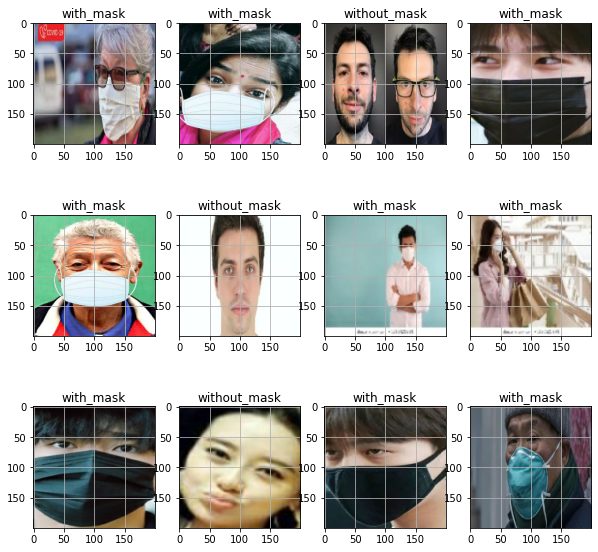

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

In [8]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Now build a deep neural network and train it and see how you do

In [9]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(4, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(1, activation='sigmoid'),
])

In [10]:
n_epochs = 10
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision(),
                        tf.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None),
                        tf.keras.metrics.TrueNegatives(thresholds=None, name=None, dtype=None),
                        tf.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None),
                        tf.keras.metrics.FalseNegatives(thresholds=None, name=None, dtype=None)
                       ])
models = model.fit(training_ds,
  validation_data=testing_ds,
  epochs=n_epochs)

Epoch 1/10
152/152 [==============================] - 83s 544ms/step - loss: 0.3898 - accuracy: 0.8223 - recall: 0.8324 - precision: 0.8195 - true_positives: 2547.0000 - true_negatives: 2422.0000 - false_positives: 561.0000 - false_negatives: 513.0000 - val_loss: 0.2672 - val_accuracy: 0.8894 - val_recall: 0.8672 - val_precision: 0.9111 - val_true_positives: 666.0000 - val_true_negatives: 677.0000 - val_false_positives: 65.0000 - val_false_negatives: 102.0000
Epoch 2/10
152/152 [==============================] - 49s 322ms/step - loss: 0.2641 - accuracy: 0.8949 - recall: 0.8980 - precision: 0.8948 - true_positives: 2748.0000 - true_negatives: 2660.0000 - false_positives: 323.0000 - false_negatives: 312.0000 - val_loss: 0.2553 - val_accuracy: 0.8940 - val_recall: 0.8607 - val_precision: 0.9258 - val_true_positives: 661.0000 - val_true_negatives: 689.0000 - val_false_positives: 53.0000 - val_false_negatives: 107.0000
Epoch 3/10
152/152 [==============================] - 49s 325ms/step - l

In [11]:
f1_train = (2*(models.history['recall'][n_epochs - 1]*models.history['precision'][n_epochs - 1])/(models.history['recall'][n_epochs - 1]+models.history['precision'][n_epochs - 1]))
f1_test = (2*(models.history['val_recall'][n_epochs - 1]*models.history['val_precision'][n_epochs - 1])/(models.history['val_recall'][n_epochs - 1]+models.history['val_precision'][n_epochs - 1]))

In [12]:
print(f1_train)
print(f1_test)

ypred = model.predict(testing_ds)
ypred = np.where(ypred > 0.5, 1, 0)
ytrue = [y for x, y in testing_ds]
ytrue = np.concatenate(ytrue)
metrics.confusion_matrix(ytrue, ypred)

0.9510922955819059
0.9298597322358716


array([[709,  33],
       [ 72, 696]], dtype=int64)

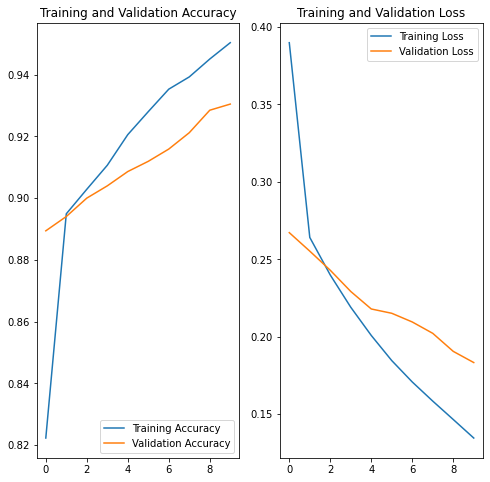

In [13]:
acc = models.history['accuracy']
val_acc = models.history['val_accuracy']

loss = models.history['loss']
val_loss = models.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()